In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import seasonal_decompose
import pmdarima as pm

In [60]:
igae = pd.read_csv('https://raw.githubusercontent.com/jimmyzac/Estadistica-Aplicada-FCFM-UANL/main/bases_datos/IGAE.csv')

In [61]:
igae.head()

,Periodos,IGAE
0,1993/01,60.407691
1,1993/02,61.022521
2,1993/03,63.943249
3,1993/04,61.865984
4,1993/05,63.612900


In [62]:
## Dar formato de fecha
igae['Periodos'] = pd.to_datetime(igae['Periodos'],format='%Y/%m')

In [63]:
## Hacerlo index y establecer frecuencia
igae = igae.set_index('Periodos')
igae=igae.asfreq('MS')

In [70]:
igae.head()

,IGAE
Periodos,
1993-01-01,60.407691
1993-02-01,61.022521
1993-03-01,63.943249
1993-04-01,61.865984
1993-05-01,63.612900


In [71]:
igae.index

DatetimeIndex(['1993-01-01', '1993-02-01', '1993-03-01', '1993-04-01',
               '1993-05-01', '1993-06-01', '1993-07-01', '1993-08-01',
               '1993-09-01', '1993-10-01',
               ...
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01'],
              dtype='datetime64[ns]', name='Periodos', length=355, freq='MS')

**6. Utiliza   la descomposición   estacional,   para   obtener   el   componente estacional, y la serie desestacionalizada.**

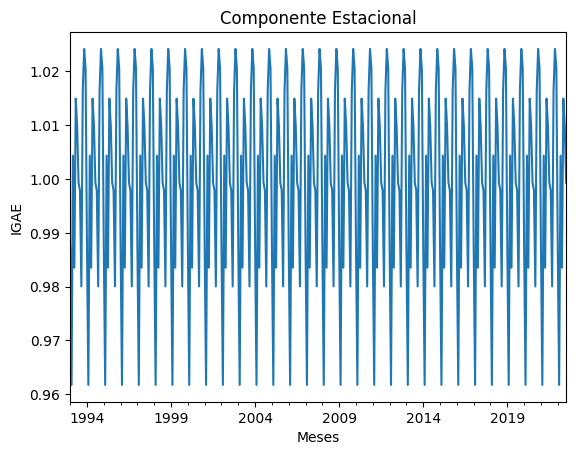

In [79]:
results = seasonal_decompose(igae['IGAE'], model='mul')
results.seasonal.plot()
plt.title('Componente Estacional');
plt.xlabel('Meses')
plt.ylabel('IGAE')
plt.show();

In [74]:
comp_est = results.seasonal
igae['IGAE_Des'] = igae['IGAE'] / comp_est

In [78]:
comp_est

Periodos
1993-01-01    0.987469
1993-02-01    0.961743
1993-03-01    1.004340
1993-04-01    0.983515
1993-05-01    1.014927
                ...   
2022-03-01    1.004340
2022-04-01    0.983515
2022-05-01    1.014927
2022-06-01    1.009777
2022-07-01    0.999301
Freq: MS, Name: seasonal, Length: 355, dtype: float64

In [75]:
igae.head()

,IGAE,IGAE_Des
Periodos,,
1993-01-01,60.407691,61.174263
1993-02-01,61.022521,63.449931
1993-03-01,63.943249,63.666953
1993-04-01,61.865984,62.902954
1993-05-01,63.612900,62.677318


**7. Utiliza la serie original para hacer el análisis ARIMA**

In [84]:
## Estimamos un ARIMA (1,1)
modelo = ARIMA(igae['IGAE'], order=(1, 1, 1))
resultado = modelo.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   IGAE   No. Observations:                  355
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -871.502
Date:                Fri, 10 Nov 2023   AIC                           1749.005
Time:                        22:44:27   BIC                           1760.613
Sample:                    01-01-1993   HQIC                          1753.623
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4083      0.072      5.703      0.000       0.268       0.549
ma.L1         -0.7962      0.062    -12.799      0.000      -0.918      -0.674
sigma2         8.0424      0.256     31.411      0.000       7.541       8.544
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2240.87
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               4.42   Skew:                            -1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**8. Realiza  una  prueba  de  raíz  unitaria  para  verificar  si  este  proceso  es estacionario (sino es estacionario conviértelo en estacionario)**

In [83]:
## Prueba de Dickey Fuller aumentada
prueba_adf = adfuller(igae['IGAE'].dropna())
pvalue = prueba_adf[1]
pvalue.round(2)

0.78

0.78 > 0.05 No rechazamos Ho, la serie es no estacionaria

In [85]:
## Aplicamos primeras diferencias
igae['igae_diff'] = igae['IGAE'].diff()


In [86]:
prueba_adf1 = adfuller(igae['igae_diff'].dropna())
pvalue = prueba_adf1[1]
pvalue.round(2)

0.0

0.0 < 0.05 Rechazamos Ho, las primeras diferencias es una serie estacionaria

**9. Con el proceso estacionario, realizalas gráficas de autocorrelación (ACF) y autocorrelación parcial (PACF) y señala como se interpretan**

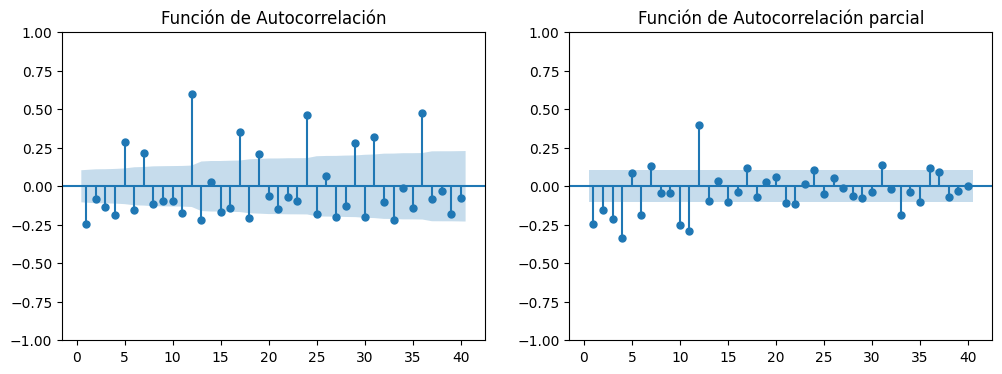

In [87]:
ig, ax=plt.subplots(1,2,figsize=(12,4))
plot_acf(igae['igae_diff'].dropna(),zero=False,lags=40,ax=ax[0],title='Función de Autocorrelación')
ax[0].set_ylim(-1,1)
plot_pacf(igae['igae_diff'].dropna(),zero=False,lags=40,ax=ax[1],title='Función de Autocorrelación parcial')
ax[1].set_ylim(-1,1);

Debido a que las gráficas presentan valores atípicos, esto nos indica que la serie no tiene un componente estacional (no sigue un patrón la gráfica)

**10. Utilizando  el  código auto_arima y  elige  un  criterio  para  seleccionar  el modelo,  ya  seael  criterio  de  akaike  (AIC)  o  el  criterio  bayesiano  de información (BIC)**

In [88]:
pm.auto_arima(igae['igae_diff'].dropna(),   
              start_p=1, max_p=7,
              start_q=1,max_q=7,
              ic='AIC',
              seasonal=True,
              m=12,
              start_P=1,start_Q=1,
              max_P=7,max_Q=7)

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(1, 0, 3, 12),
      suppress_warnings=True, with_intercept=False)